In [24]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
from cirq.contrib.svg import SVGCircuit

In [25]:
q0, q1, q2, q3, q4, q5 = sympy.symbols('q0 q1 q2 q3 q4 q5')
z0, z1, z2, z3, z4, z5 = sympy.symbols('z0 z1 z2 z3 z4 z5')
K = sympy.symbols('K')

In [26]:
qubo1 = 4*q0+4*q0*q1+8*q0*q3+4*q0*q4+4*q1+2*q1*q2+4*q1*q3+8*q1*q4+2*q1*q5+4*q2+2*q2*q4+8*q2*q5+4*q3+4*q3*q4+4*q4+2*q4*q5+4*q5

qubo2 = -K*q0+2*K*q0*q1+2*K*q0*q2-K*q1+2*K*q1*q2-K*q2-K*q3+2*K*q3*q4+2*K*q3*q5-K*q4+2*K*q4*q5-K*q5

qubo = qubo1 + qubo2
print(qubo)

2*K*q0*q1 + 2*K*q0*q2 - K*q0 + 2*K*q1*q2 - K*q1 - K*q2 + 2*K*q3*q4 + 2*K*q3*q5 - K*q3 + 2*K*q4*q5 - K*q4 - K*q5 + 4*q0*q1 + 8*q0*q3 + 4*q0*q4 + 4*q0 + 2*q1*q2 + 4*q1*q3 + 8*q1*q4 + 2*q1*q5 + 4*q1 + 2*q2*q4 + 8*q2*q5 + 4*q2 + 4*q3*q4 + 4*q3 + 2*q4*q5 + 4*q4 + 4*q5


In [27]:
H = qubo.subs([(q0, ((1-z0)/2)), (q1, ((1-z1)/2)), (q2, ((1-z2)/2)), (q3, ((1-z3)/2)), (q4, ((1-z4)/2)), (q5, ((1-z5)/2))])

In [28]:
H_symbol = H.simplify()
H_symbol

K*z0*z1/2 + K*z0*z2/2 - K*z0/2 + K*z1*z2/2 - K*z1/2 - K*z2/2 + K*z3*z4/2 + K*z3*z5/2 - K*z3/2 + K*z4*z5/2 - K*z4/2 - K*z5/2 + z0*z1 + 2*z0*z3 + z0*z4 - 6*z0 + z1*z2/2 + z1*z3 + 2*z1*z4 + z1*z5/2 - 7*z1 + z2*z4/2 + 2*z2*z5 - 5*z2 + z3*z4 - 6*z3 + z4*z5/2 - 7*z4 - 5*z5 + 24

In [29]:
def CostUnitary(circuit, control_params, i, K):
    circuit.append(cirq.ZZ(qubits[0], qubits[1])**((K / 2 + 1) * control_params[i]))
    circuit.append(cirq.ZZ(qubits[0], qubits[2])**(K / 2 * control_params[i]))
    circuit.append(cirq.Z(qubits[0])**((-K / 2 - 6) * control_params[i]))
    circuit.append(cirq.ZZ(qubits[1], qubits[2])**((K + 1) / 2 * control_params[i]))
    circuit.append(cirq.Z(qubits[1])**((- K / 2 - 7) * control_params[i]))
    circuit.append(cirq.Z(qubits[2])**((- K / 2 - 5) * control_params[i]))
    circuit.append(cirq.ZZ(qubits[3], qubits[4])**((K / 2 + 1) * control_params[i]))
    circuit.append(cirq.ZZ(qubits[3], qubits[5])**(K / 2 * control_params[i]))
    circuit.append(cirq.Z(qubits[3])**((- K / 2 - 6) * control_params[i]))
    circuit.append(cirq.ZZ(qubits[4], qubits[5])**((K + 1) / 2 * control_params[i]))
    circuit.append(cirq.Z(qubits[4])**((- K / 2 - 7) * control_params[i]))
    circuit.append(cirq.Z(qubits[5])**((- K / 2 - 5) * control_params[i]))
    circuit.append(cirq.ZZ(qubits[0], qubits[3])**(2 * control_params[i]))
    circuit.append(cirq.ZZ(qubits[0], qubits[4])**(control_params[i]))
    circuit.append(cirq.ZZ(qubits[1], qubits[3])**(control_params[i]))
    circuit.append(cirq.ZZ(qubits[1], qubits[4])**(2 * control_params[i]))
    circuit.append(cirq.ZZ(qubits[1], qubits[5])**(1 / 2 * control_params[i]))
    circuit.append(cirq.ZZ(qubits[2], qubits[4])**(1 / 2 * control_params[i]))
    circuit.append(cirq.ZZ(qubits[2], qubits[5])**(2 * control_params[i]))
    return circuit
    
def Mixer(circuit, i, N):
    for j in range(N):
        circuit.append(cirq.XPowGate(exponent = control_params[i]).on(qubits[j]))
    return circuit

def init_circuit(N):
    initCircuit = cirq.Circuit()
    qubits = cirq.GridQubit.rect(1, N)
    for j in range(N):
        initCircuit.append(cirq.H(qubits[j]))
    return initCircuit

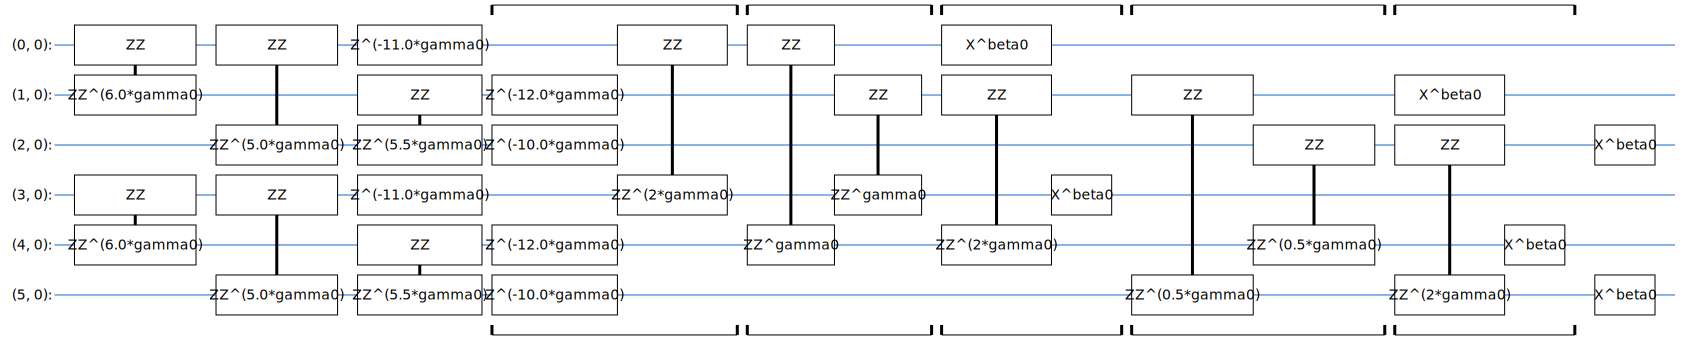

In [30]:
p = 1
N = 6
K = 10
control_params = []
for i in range(p):
    gamma = 'gamma' + str(i)
    beta = 'beta' + str(i)
    control_params.append(sympy.symbols(gamma))
    control_params.append(sympy.symbols(beta))

#qubits = cirq.GridQubit.rect(1, N)
qubits = [cirq.GridQubit(i, 0) for i in range(N)]
model_circuit = cirq.Circuit()
for i in range(p):
    model_circuit = CostUnitary(model_circuit, control_params, 2 * i, K)
    model_circuit = Mixer(model_circuit, 2 * i + 1, N)

# resolver = cirq.ParamResolver({K: 1, control_params[0]: 0.3, control_params[1]: 0.6})
# output_state_vector = cirq.Simulator().simulate(model_circuit, resolver).final_state
# print(output_state_vector)

# Z = 0
# for i in range(N):
#     Z += cirq.Z(qubits[i])
# print(Z)

# qubit_map={qubits[0]: 0, qubits[1]: 1, qubits[2]: 2, qubits[3]: 3, qubits[4]: 4, qubits[5]: 5}
# print(Z.expectation_from_wavefunction(output_state_vector, qubit_map).real)

SVGCircuit(model_circuit)

In [31]:
controller = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='elu'),
    tf.keras.layers.Dense(len(control_params))
])

In [32]:
datapoint_circuits = tfq.convert_to_tensor([init_circuit(N)])

commands_input = tf.keras.layers.Input(shape=(1),
                                       dtype=tf.dtypes.float32,
                                       name='commands_input')
circuits_input = tf.keras.Input(shape=(),
                                # The circuit-tensor has dtype `tf.string` 
                                dtype=tf.dtypes.string,
                                name='circuits_input')
operators_input = tf.keras.Input(shape=(1,),
                                 dtype=tf.dtypes.string,
                                 name='operators_input')

In [33]:
dense_2 = controller(commands_input) # tf.keras.Sequential
full_circuit = tfq.layers.AddCircuit()(circuits_input, append=model_circuit)
expectation_output = tfq.layers.Expectation()(full_circuit,
                                              symbol_names=control_params,
                                              symbol_values=dense_2,
                                              operators=operators_input)

model = tf.keras.Model(
    inputs=[circuits_input, commands_input, operators_input],
    outputs=[expectation_output])

In [39]:
def ZZoperator(i, j):
    return cirq.Z(qubits[i]) * cirq.Z(qubits[j])

operators = [[-1 * ((K / 2 + 1) * ZZoperator(0, 1) + (K / 2) * ZZoperator(0, 2) - \
            (K / 2 + 6) * cirq.Z(qubits[0]) + (K / 2 + 1 / 2) * ZZoperator(1, 2) - \
            (K / 2 + 7) * cirq.Z(qubits[1]) - (K / 2 + 5) * cirq.Z(qubits[2]) + \
            (K / 2 + 1) * ZZoperator(3, 4) + (K / 2) * ZZoperator(3, 5) - \
            (K / 2 + 6) * cirq.Z(qubits[3]) + (K / 2 + 1 / 2) * ZZoperator(4, 5) - \
            (K / 2 + 7) * cirq.Z(qubits[4]) - (K / 2 + 5) * cirq.Z(qubits[5]) + \
            2 * ZZoperator(0, 3) + ZZoperator(0, 4) + ZZoperator(1, 3) + 2 * ZZoperator(1, 4) +\
            1 / 2 * ZZoperator(1, 5) + 1 / 2 * ZZoperator(2, 4) + 2 * ZZoperator(2, 5) + 2 * K + 24)]]

In [40]:
# The operators to measure, for each command.
operator_data = tfq.convert_to_tensor(operators)
#operator_data = tfq.convert_to_tensor([[cirq.X(qubits[0])], [cirq.Z(qubits[0])]])

# The command input values to the classical NN.
commands = np.array([[1] for i in range(len(operators))], dtype=np.float32)

# The desired expectation value at output of quantum circuit.
expected_outputs = np.array([[10] for i in range(len(operators))], dtype=np.float32)

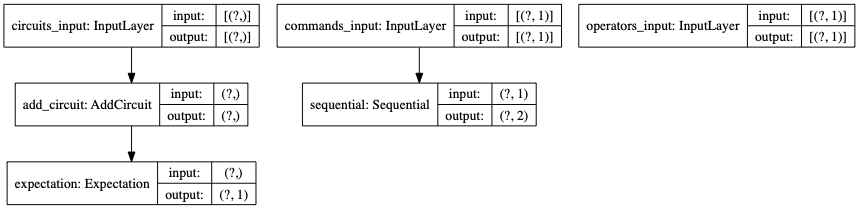

In [41]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
loss = tf.keras.losses.MeanSquaredError()

model.compile(optimizer=optimizer, loss=loss)

tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)

In [42]:
history = model.fit(
    x=[datapoint_circuits, commands, operator_data],
    y=expected_outputs,
    epochs=100,
    verbose=0)

In [43]:
model([datapoint_circuits, commands, operator_data])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-16.300694]], dtype=float32)>

In [44]:
after_params = controller.predict(np.array([1]))[0]
print(after_params)

[-2.498331   -0.10689228]


In [45]:
param_dict = {sympy.symbols('K'): K}
for i in range(len(control_params)):
    param_dict.update([(control_params[i], after_params[i])])
resolver = cirq.ParamResolver(param_dict)
output_state_vector = cirq.Simulator().simulate(model_circuit, resolver).final_state

In [46]:
resolver

cirq.ParamResolver({sympy.Symbol('K'): 10, sympy.Symbol('gamma0'): -2.498331, sympy.Symbol('beta0'): -0.10689228})

In [47]:
simulator = cirq.Simulator()
#result = cirq.Simulator().simulate(model_circuit, resolver)
model_circuit.append(cirq.measure(*qubits, key = 'm'))
results = simulator.run(model_circuit, resolver, repetitions=100)

In [48]:
def calc_cost(state, operator):
    qubits = [cirq.GridQubit(i, 0) for i in range(len(state))]
    test_circuit = cirq.Circuit()
    for i in range(len(state)):
        if state[i] == '1':
            test_circuit.append(cirq.X(qubits[i]))
        else:
            test_circuit.append(cirq.I(qubits[i]))

    output_state_vector = cirq.Simulator().simulate(test_circuit).final_state
    qubit_map={qubits[0]: 0, qubits[1]: 1, qubits[2]: 2, qubits[3]: 3, qubits[4]: 4, qubits[5]: 5}
    return operator.expectation_from_wavefunction(output_state_vector, qubit_map).real

hist = results.histogram(key='m')
keys = list(hist.keys())
for key in keys:
    binary = '{:0=6b}'.format(key)
    print(binary, ':',  hist[key], calc_cost(binary, operators[0][0]))

001000 : 2 -14.0
000000 : 84 -20.0
000001 : 6 -14.0
001100 : 1 -8.0
000010 : 4 -14.0
010000 : 2 -14.0
000100 : 1 -14.0


In [14]:
q0, q1 = cirq.GridQubit.rect(1, 2) 
alpha = sympy.Symbol('alpha') # degree of entanglement between q0, q1 
parametrized_bell_circuit = cirq.Circuit( 
   cirq.H(q0), cirq.CNOT(q0, q1) ** alpha)

state_layer = tfq.layers.State() 
alphas = [[0]] # FIXME: #805 
state = state_layer(parametrized_bell_circuit, 
    symbol_names=[alpha], symbol_values=alphas)

In [18]:
state[0]

<tf.Tensor: shape=(4,), dtype=complex64, numpy=
array([0.70710677-1.2802769e-08j, 0.        +0.0000000e+00j,
       0.70710677+3.0908620e-08j, 0.        +0.0000000e+00j],
      dtype=complex64)>

In [23]:
expected_state = np.zeros(16, dtype=np.complex64)
expected_state[0] = 1.
tf.constant([expected_state], dtype=tf.complex64)

<tf.Tensor: shape=(1, 16), dtype=complex64, numpy=
array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]],
      dtype=complex64)>